# Introduction

<!-- <img src="assets/o3a_strain_sensitivity_curve.png"> -->

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, json, csv, datetime, sys, collections, traceback, textwrap
from pprint import pprint
import pandas as pd
import numpy as np
# sys.path.append('../src/')
PROJECT_DIR = os.path.abspath(os.path.join(os.pardir))
PROJECT_DIR

'/home/rutuja.gurav/ligo_gwsearch_with_glitches/src/matrix_profile_analyses'

In [4]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
from gwpy.timeseries import TimeSeries, TimeSeriesDict, TimeSeriesList, StateTimeSeries
from gwpy.segments import DataQualityFlag, DataQualityDict
from gwpy.table import EventTable
from gwpy.plot import Plot
from gwpy.time import to_gps, from_gps

In [5]:
from plotting_utils import *

# Creating the dataset

## Load the events catalogs

In [6]:
gwtc_catalog = EventTable.fetch_open_data("GWTC").to_pandas().sort_values(by="GPS")
gwtc_catalog

,chirp_mass_source_lower,chi_eff,final_mass_source_lower,final_mass_source_upper,mass_1_source_upper,total_mass_source_upper,GPS,chi_eff_lower,p_astro_lower,catalog.shortName,...,mass_1_source,luminosity_distance_lower,mass_2_source,luminosity_distance,luminosity_distance_upper,total_mass_source,network_matched_filter_snr,p_astro,jsonurl,chirp_mass_upper
name,,,,,,,,,,,,,,,,,,,,,
GW150914-v3,-1.5,-0.01,-3.0,3.4,4.7,None,1.126259e+09,-0.13,None,GWTC-1-confident,...,35.6,-170.0,30.6,440.0,150.0,None,26.0,1.0,http://gwosc.org/eventapi/json/GWTC-1-confiden...,None
GW151012-v3,-1.2,0.05,-3.8,10.8,14.9,None,1.128679e+09,-0.2,None,GWTC-1-confident,...,23.2,-490.0,13.6,1080.0,550.0,None,10.0,1.0,http://gwosc.org/eventapi/json/GWTC-1-confiden...,None
GW151226-v2,-0.3,0.18,-1.5,6.4,8.8,None,1.135136e+09,-0.12,None,GWTC-1-confident,...,13.7,-190.0,7.7,450.0,180.0,None,13.1,1.0,http://gwosc.org/eventapi/json/GWTC-1-confiden...,None
GW170104-v2,-1.8,-0.04,-4.0,5.1,7.3,None,1.167560e+09,-0.21,None,GWTC-1-confident,...,30.8,-430.0,20.0,990.0,440.0,None,13.8,1.0,http://gwosc.org/eventapi/json/GWTC-1-confiden...,None
GW170608-v3,-0.2,0.03,-0.7,3.4,5.5,None,1.180922e+09,-0.07,None,GWTC-1-confident,...,11.0,-110.0,7.6,320.0,120.0,None,15.4,1.0,http://gwosc.org/eventapi/json/GWTC-1-confiden...,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GW200306_093714-v1,-3.0,0.32,-6.9,12.3,17.1,11.8,1.267523e+09,-0.46,None,GWTC-3-confident,...,28.3,-1100.0,14.8,2100.0,1700.0,43.9,7.8,0.81156,http://gwosc.org/eventapi/json/GWTC-3-confiden...,None
GW200308_173609-v1,-18.0,0.16,-47.0,169.0,166.0,169.0,1.267724e+09,-0.49,None,GWTC-3-confident,...,60.0,-4400.0,24.0,7100.0,13900.0,92.0,4.7,0.8566,http://gwosc.org/eventapi/json/GWTC-3-confiden...,None
GW200311_115853-v1,-2.0,-0.02,-3.9,4.8,6.4,5.3,1.267963e+09,-0.2,None,GWTC-3-confident,...,34.2,-400.0,27.7,1170.0,280.0,61.9,17.8,0.99,http://gwosc.org/eventapi/json/GWTC-3-confiden...,None


In [7]:
print(gwtc_catalog['catalog.shortName'].unique())
gwtc_catalog_confident = gwtc_catalog[gwtc_catalog['catalog.shortName'].str.contains('confident')]
len(gwtc_catalog_confident)

['GWTC-1-confident' 'GWTC-2.1-confident' 'GWTC-2.1-auxiliary'
 'GWTC-2.1-marginal' 'GWTC-3-confident']


90

In [9]:
gwtc_catalog.to_csv(os.path.join(PROJECT_DIR, "data/GWTC_metadata.csv"))

## Plot some events

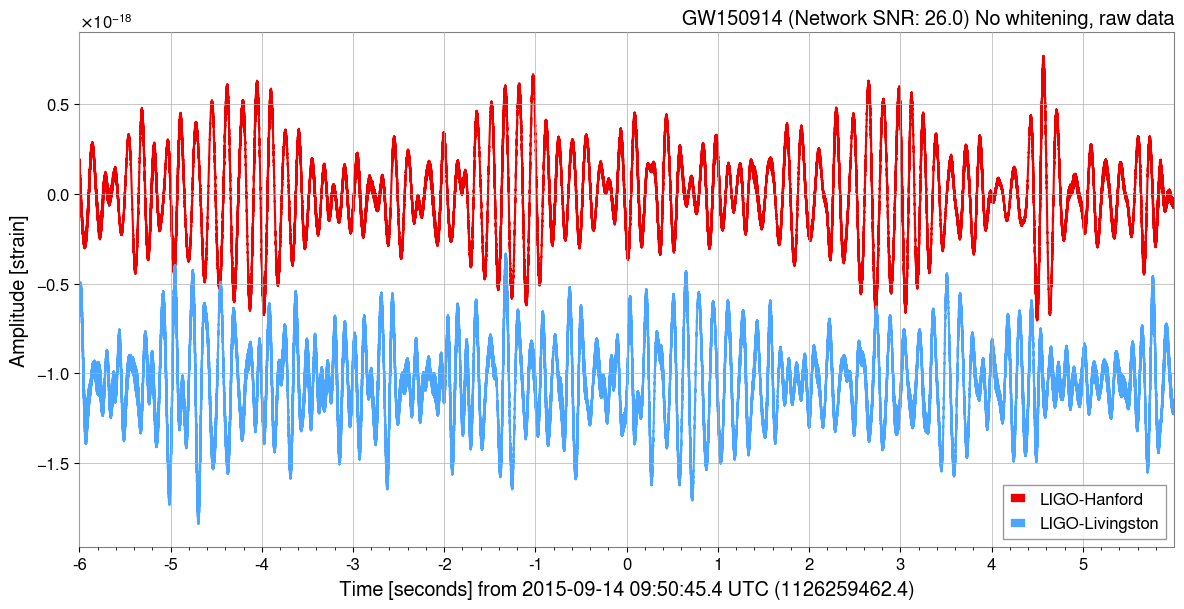

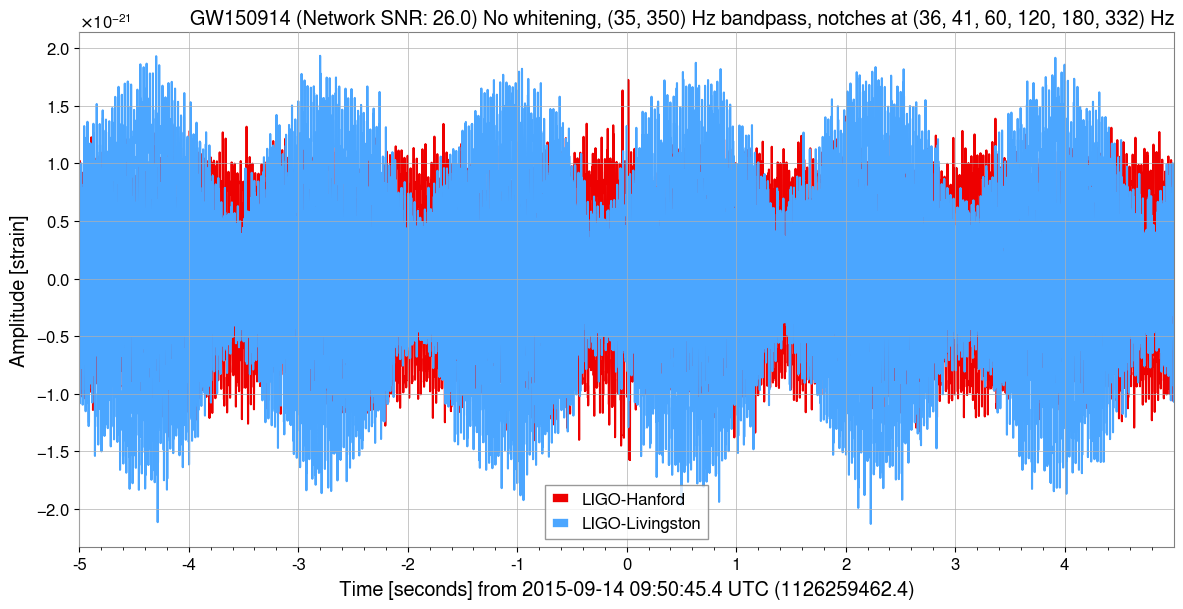

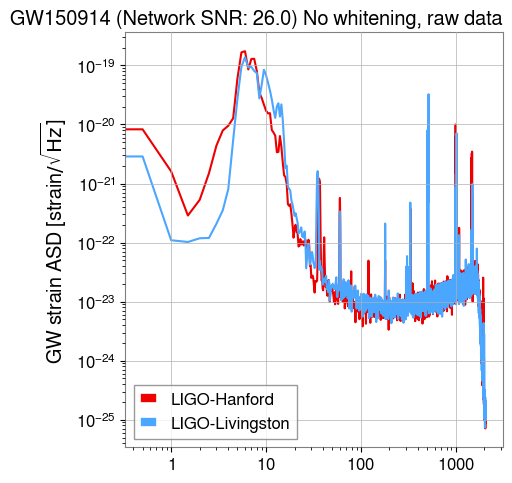

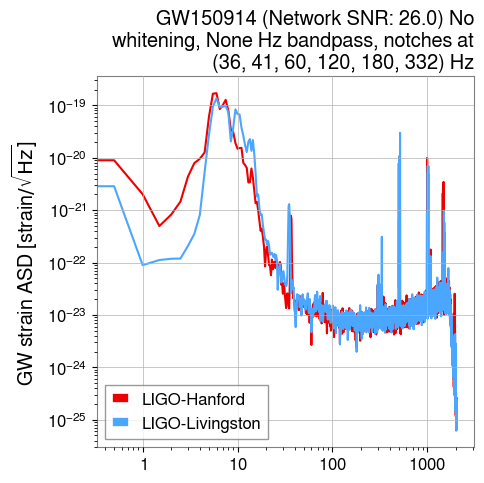

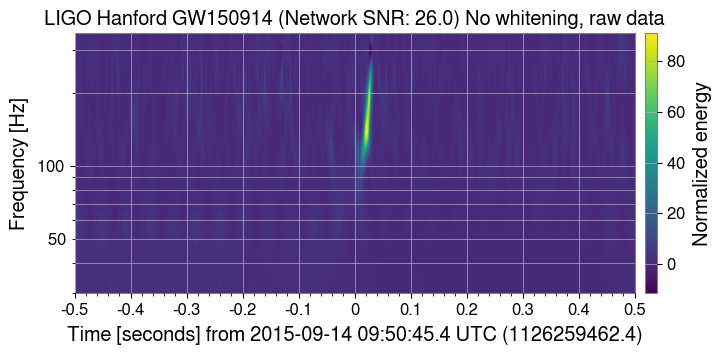

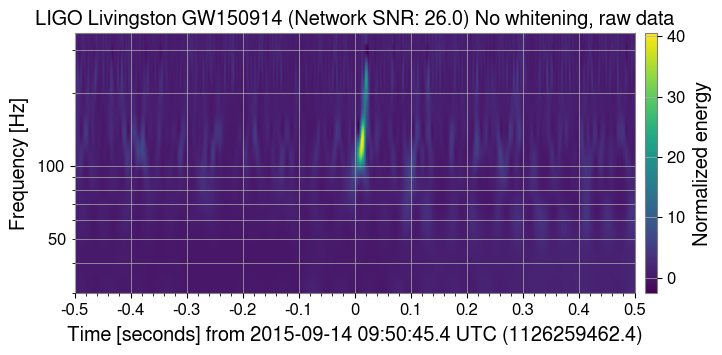

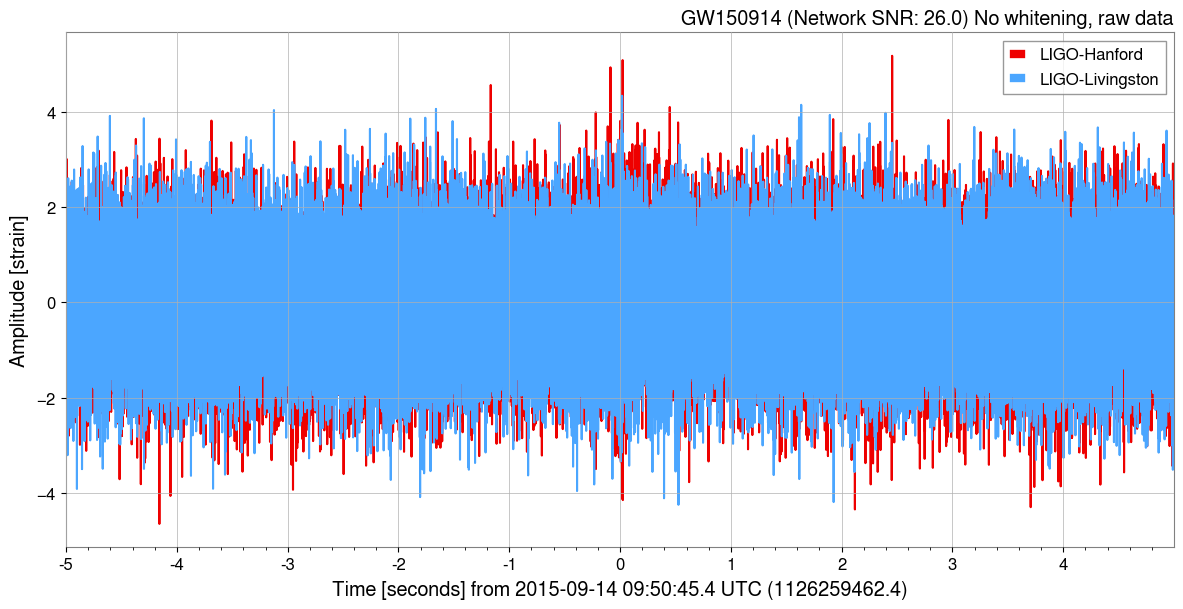

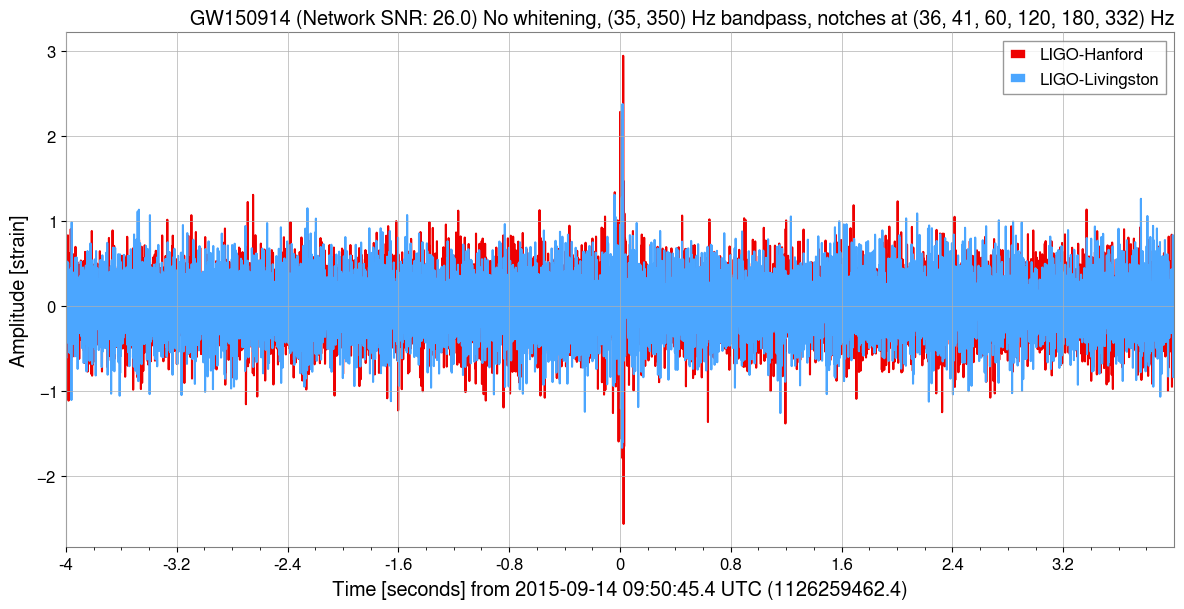

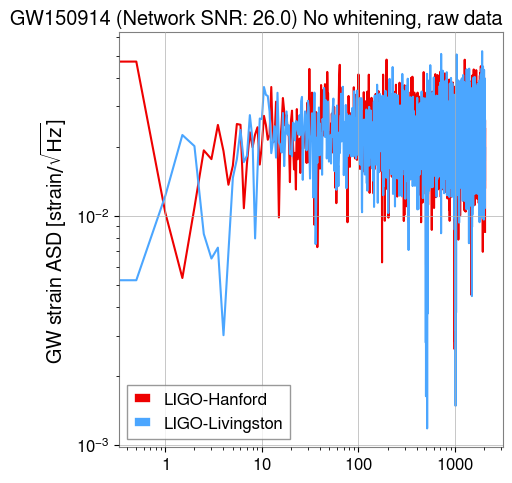

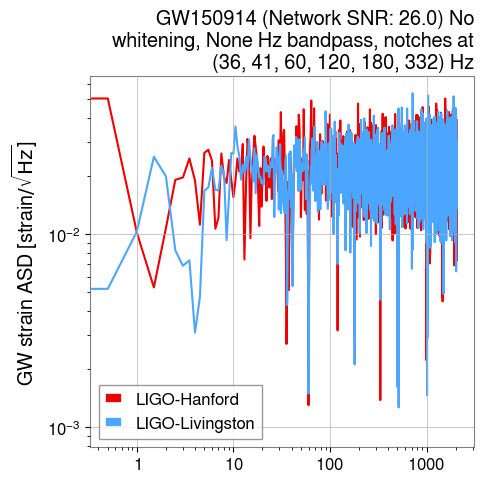

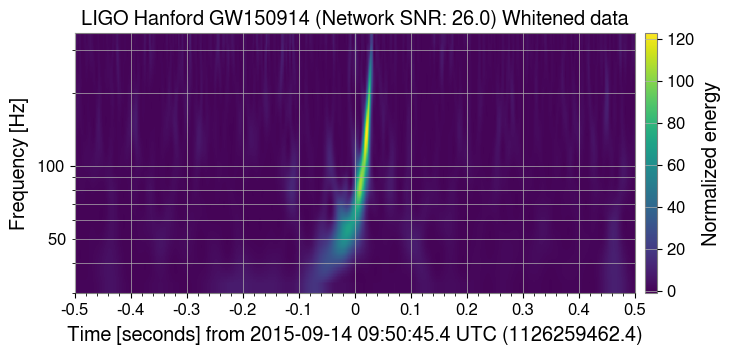

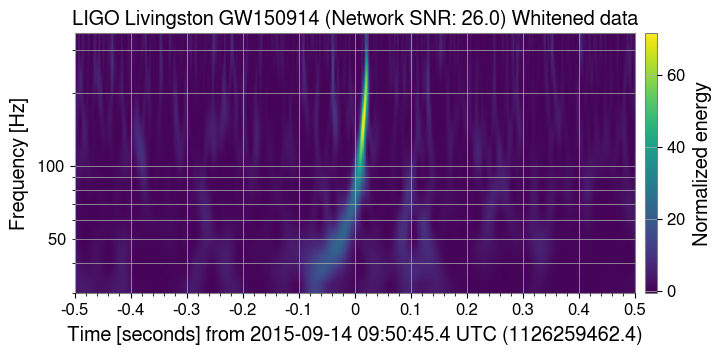

In [10]:
events_subset = [
                  'GW150914', 
                  # 'GW170817', 
                  # 'GW170823', 
                  # 'GW200224_222234'
                ]
for index, event in gwtc_catalog[gwtc_catalog.commonName.isin(events_subset)].iterrows():
# for index, event in gwtc_catalog.head(3).iterrows():
    event_gps = event['GPS']
    event_name = event['commonName']
    snr = event['network_matched_filter_snr']
    try:
        ## Fetch the data
        if event_name == 'GW170817':
            hdata = TimeSeries.fetch_open_data('H1', event_gps-30, event_gps+5)
            ldata = TimeSeries.fetch_open_data('L1', event_gps-30, event_gps+5)
        else:
            hdata = TimeSeries.fetch_open_data('H1', event_gps-6, event_gps+6)
            ldata = TimeSeries.fetch_open_data('L1', event_gps-6, event_gps+6)

        # ldata.shift('6.9ms')

        bandpass_freq, notch_freqs = (35,350), (36,41,60,120,180,332)
        plot_event_ts(hdata, ldata, event_gps, titlestr=event_name+f" (Network SNR: {snr}) No whitening, raw data")
        plot_event_ts(hdata, ldata, event_gps, preprocess_params={'bandpass_freq': bandpass_freq, 'notch_freqs': notch_freqs}, 
                      titlestr=event_name+f" (Network SNR: {snr}) No whitening, {bandpass_freq} Hz bandpass, notches at {notch_freqs} Hz")

        bandpass_freq, notch_freqs = None, (36,41,60,120,180,332)
        plot_event_asd(hdata, ldata, titlestr=event_name+f" (Network SNR: {snr}) No whitening, raw data")
        plot_event_asd(hdata, ldata, preprocess_params={'bandpass_freq': bandpass_freq, 'notch_freqs': notch_freqs}, 
                       titlestr='\n'.join(textwrap.wrap(event_name+f" (Network SNR: {snr}) No whitening, {bandpass_freq} Hz bandpass, notches at {notch_freqs} Hz", 40)))

        if event_name == 'GW170817':
            plot_event_qtransform(  hdata, ldata,
                                    event_gps=event_gps,
                                    delta_outseg = (20, 2),
                                    freq_range = (30, 500),
                                    qrange=(80,110),
                                    clim={'H1': None, 'L1':(0,20)},
                                    titlestr=event_name+f" (Network SNR: {snr}) No whitening, raw data")
        else:
            plot_event_qtransform(hdata, ldata, event_gps=event_gps, delta_outseg=(0.5,0.5), titlestr=event_name+f" (Network SNR: {snr}) No whitening, raw data")

        hdata = hdata.whiten().crop(*hdata.span.contract(1))
        ldata = ldata.whiten().crop(*ldata.span.contract(1))

        bandpass_freq, notch_freqs = (35,350), (36,41,60,120,180,332)
        plot_event_ts(hdata, ldata, event_gps=event_gps, titlestr=event_name+f" (Network SNR: {snr}) No whitening, raw data")
        plot_event_ts(hdata, ldata, event_gps, preprocess_params={'bandpass_freq': bandpass_freq, 'notch_freqs': notch_freqs}, 
                      titlestr=event_name+f" (Network SNR: {snr}) No whitening, {bandpass_freq} Hz bandpass, notches at {notch_freqs} Hz")

        bandpass_freq, notch_freqs = None, (36,41,60,120,180,332)
        plot_event_asd(hdata, ldata, titlestr=event_name+f" (Network SNR: {snr}) No whitening, raw data")
        plot_event_asd(hdata, ldata, preprocess_params={'bandpass_freq': bandpass_freq, 'notch_freqs': notch_freqs}, 
                       titlestr='\n'.join(textwrap.wrap(event_name+f" (Network SNR: {snr}) No whitening, {bandpass_freq} Hz bandpass, notches at {notch_freqs} Hz", 40)))

        if event_name == 'GW170817':
            plot_event_qtransform(  hdata, ldata,
                                    event_gps=event_gps,
                                    delta_outseg = (20, 2),
                                    freq_range = (30, 500),
                                    qrange=(80,110),
                                    clim={'H1': None, 'L1':(0,20)},
                                    titlestr=event_name+f" (Network SNR: {snr}) Whitened data")
        else:
            plot_event_qtransform(hdata, ldata, event_gps=event_gps, delta_outseg=(0.5,0.5), titlestr=event_name+f" (Network SNR: {snr}) Whitened data")

    except Exception as e:
        traceback.print_exc()
        continue

## Concatenate all events into a single timeseries

In [11]:
from preprocess import preprocess_ts, znorm_ts

In [11]:
H1_data, L1_data, data_labels, event_names = [], [], [], []
for i, (index, event) in enumerate(gwtc_catalog.iterrows()):
# for index, event in gwtc_catalog[gwtc_catalog.commonName.isin(events_subset)].iterrows():
    if event['commonName'] == 'GW170817': continue
    event_gps = event['GPS']
    # print(event['commonName'])
    
    try: 
        hdata = TimeSeries.fetch_open_data('H1', event_gps-4, event_gps+4)
        ldata = TimeSeries.fetch_open_data('L1', event_gps-4, event_gps+4)
        # print(hdata.value.shape, ldata.value.shape)
        
        hdata = hdata.whiten().crop(*hdata.span.contract(1))
        ldata = ldata.whiten().crop(*ldata.span.contract(1))
        # print(hdata.value.shape, ldata.value.shape)

        hdata = hdata.taper()
        ldata = ldata.taper()
        # print(hdata.value.shape, ldata.value.shape)

        annot_len = int(hdata.sample_rate.value*0.01)
        labels = np.zeros(hdata.value.shape[0])
        labels[(len(hdata.value)//2)-annot_len:(len(hdata.value)//2)+(annot_len//2)] = [1]*(annot_len + annot_len//2)
        # labels[len(hdata.value)//2] = 1 ## Just mark the event GPS as the label as we don't know the duration of each event

        if i != len(gwtc_catalog)-1:
            padding_len = 100
            low_val, high_val = -1,1 #1e-23, 1e-22
            padded_hdata = np.append(hdata.value, np.random.uniform(low=low_val, high=high_val, size=padding_len))
            padded_ldata = np.append(ldata.value, np.random.uniform(low=low_val, high=high_val, size=padding_len))
            padded_data_labels = np.append(labels, np.zeros(padding_len))

        else:
            padded_hdata = hdata.value
            padded_ldata = ldata.value

            padded_data_labels = labels

        H1_data.append(padded_hdata)
        L1_data.append(padded_ldata)

        data_labels.append(padded_data_labels.astype(int))
        event_names.append([event['commonName']]*len(padded_hdata))

    except Exception as e:
        print(e)
        continue

H1_data = np.concatenate(H1_data)
L1_data = np.concatenate(L1_data)
data_labels = np.concatenate(data_labels)
event_names = np.concatenate(event_names)

print(H1_data.shape, L1_data.shape, data_labels.shape, event_names.shape)

Cannot find a GWOSC dataset for H1 covering [1240164422, 1240164431)
index 0 is out of bounds for axis 0 with size 0
Cannot find a GWOSC dataset for H1 covering [1245035075, 1245035084)
Cannot find a GWOSC dataset for H1 covering [1245955939, 1245955948)
Cannot find a GWOSC dataset for H1 covering [1246663511, 1246663520)
index 0 is out of bounds for axis 0 with size 0
Cannot find a GWOSC dataset for L1 covering [1253489339, 1253489348)
Cannot find a GWOSC dataset for L1 covering [1260567232, 1260567241)
Cannot find a GWOSC dataset for H1 covering [1262879932, 1262879940)
Cannot find a GWOSC dataset for L1 covering [1267149505, 1267149514)
(2023332,) (2023332,) (2023332,) (2023332,)


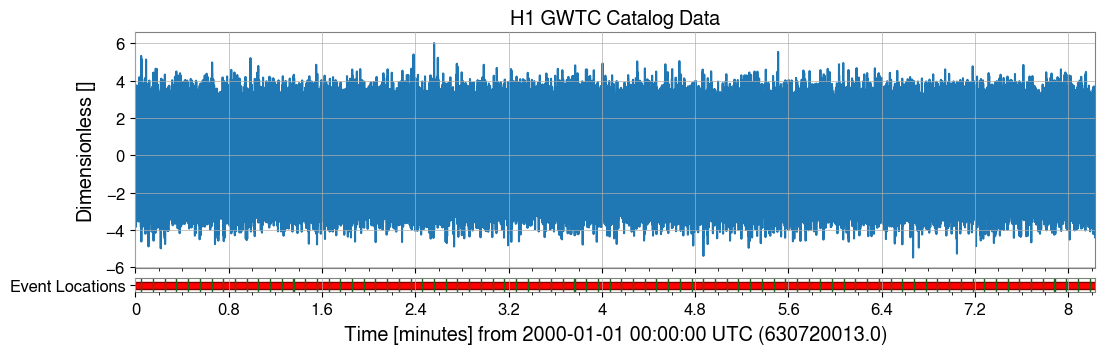

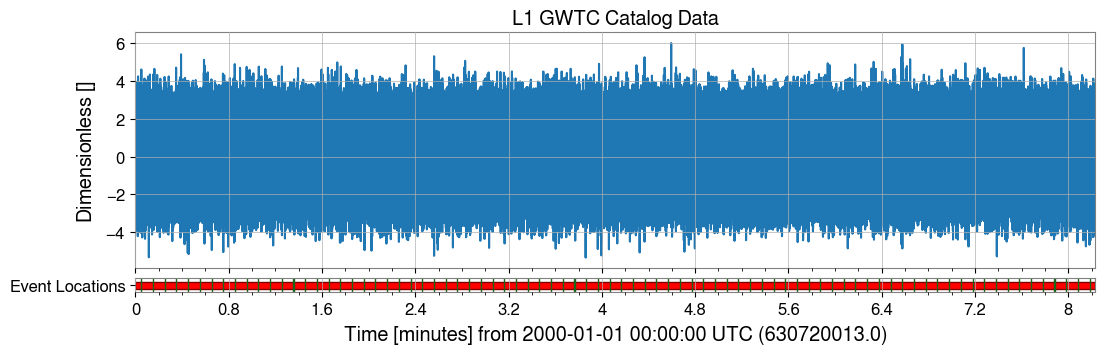

In [12]:
H1_data_ts = TimeSeries(H1_data, t0=to_gps('2000-01-01T00:00:00'), dt=1/4096)
L1_data_ts = TimeSeries(L1_data, t0=to_gps('2000-01-01T00:00:00'), dt=1/4096)
labels_ts = TimeSeries(data_labels, t0=to_gps('2000-01-01T00:00:00'), dt=1/4096)
labels_dqf = StateTimeSeries(data_labels, t0=to_gps('2000-01-01T00:00:00'), dt=1/4096).to_dqflag(name="Event Locations")

plot = H1_data_ts.plot(title=f"H1 GWTC Catalog Data").add_segments_bar(labels_dqf)
plot = L1_data_ts.plot(title=f"L1 GWTC Catalog Data").add_segments_bar(labels_dqf)
# plot = labels_ts.plot(title="L1 Event Locations")

In [14]:
with open(f"{PROJECT_DIR}/data/H1_GWTC_data.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(H1_data)

with open(f"{PROJECT_DIR}/data/L1_GWTC_data.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(L1_data)

with open(f"{PROJECT_DIR}/data/labels.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(data_labels)

### Matrix Profile Analyses for the concatenated events timeseries

In [15]:
%matplotlib inline
import mp_utils
motif_len = 400

#### Self-join: SCAMP

In [16]:
H1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, m=motif_len, algo='scamp')
H1_data_mp.shape

Computing the Exact Matrix Profile using SCAMP...
	(timeseries length = 2023332, subsequence length = 400)...
DONE.
Time taken: 0:00:11.609917


(2022933, 2)

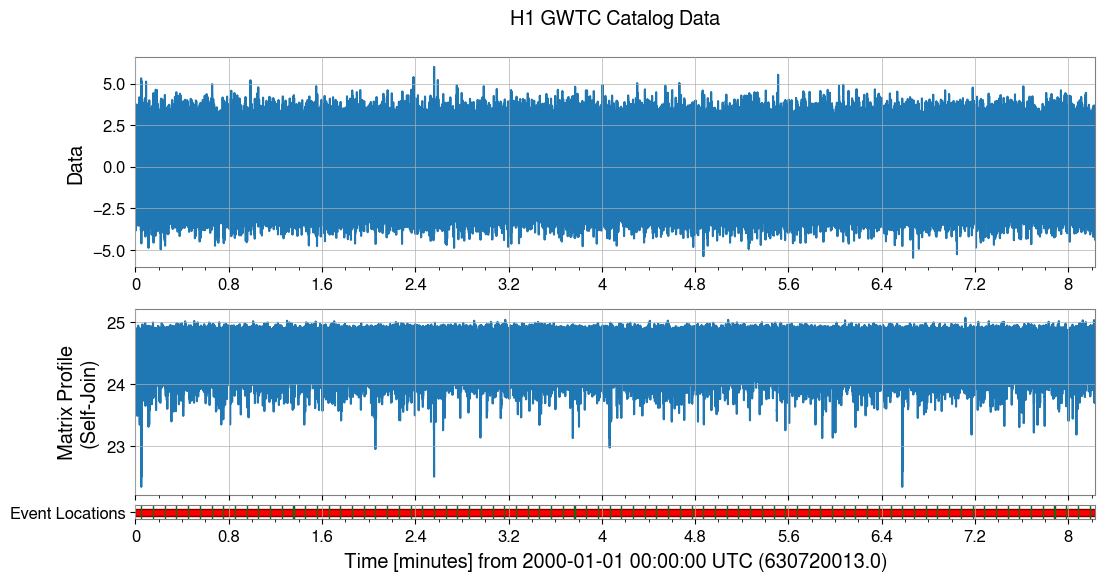

In [24]:
%matplotlib inline
plot = mp_utils.plot_matrix_profile(H1_data_ts, mp=H1_data_mp, dqf=labels_dqf, titlestr="H1 GWTC Catalog Data")

In [26]:
for ax in plot.axes:
    print(ax.__class__)

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'gwpy.plot.segments.SegmentAxes'>


In [27]:
L1_data_mp = mp_utils.compute_matrix_profile(L1_data_ts.value, m=motif_len, algo='scamp')
L1_data_mp.shape

Computing the Exact Matrix Profile using SCAMP...
	(timeseries length = 2023332, subsequence length = 400)...
DONE.
Time taken: 0:00:10.918578


(2022933, 2)

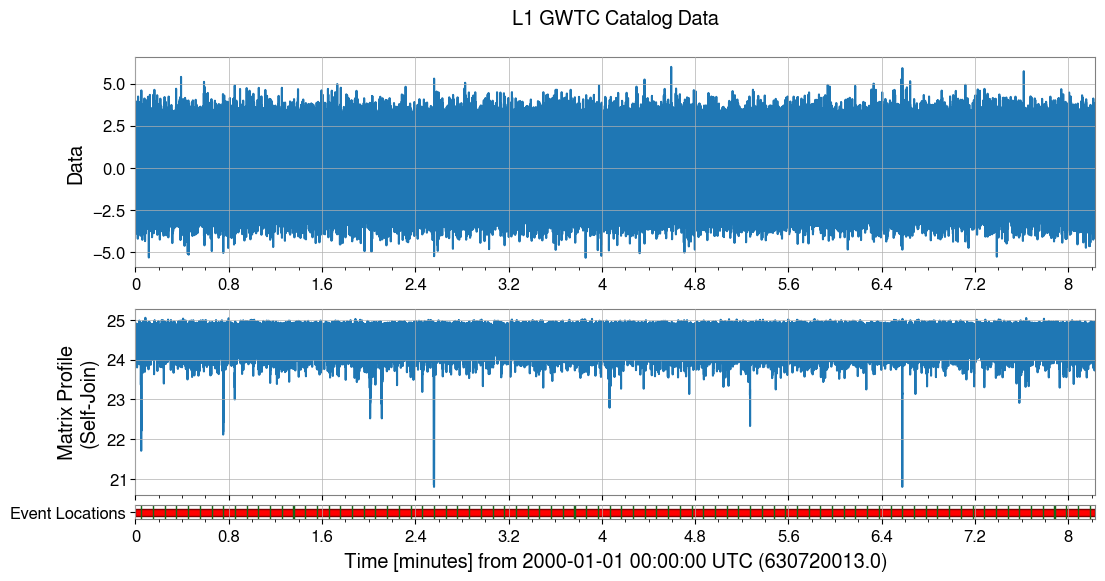

In [28]:
plot = mp_utils.plot_matrix_profile(L1_data_ts, mp=L1_data_mp, dqf=labels_dqf, titlestr="L1 GWTC Catalog Data")

#### AB-join: SCAMP

In [29]:
H1_L1_data_mp = mp_utils.compute_matrix_profile(L1_data_ts.value, T_B=H1_data_ts.value, m=motif_len, algo='scamp')
H1_L1_data_mp.shape

Computing the Exact Matrix Profile using SCAMP...
	(timeseries length = 2023332, subsequence length = 400)...
DONE.
Time taken: 0:00:14.542444


(2022933, 2)

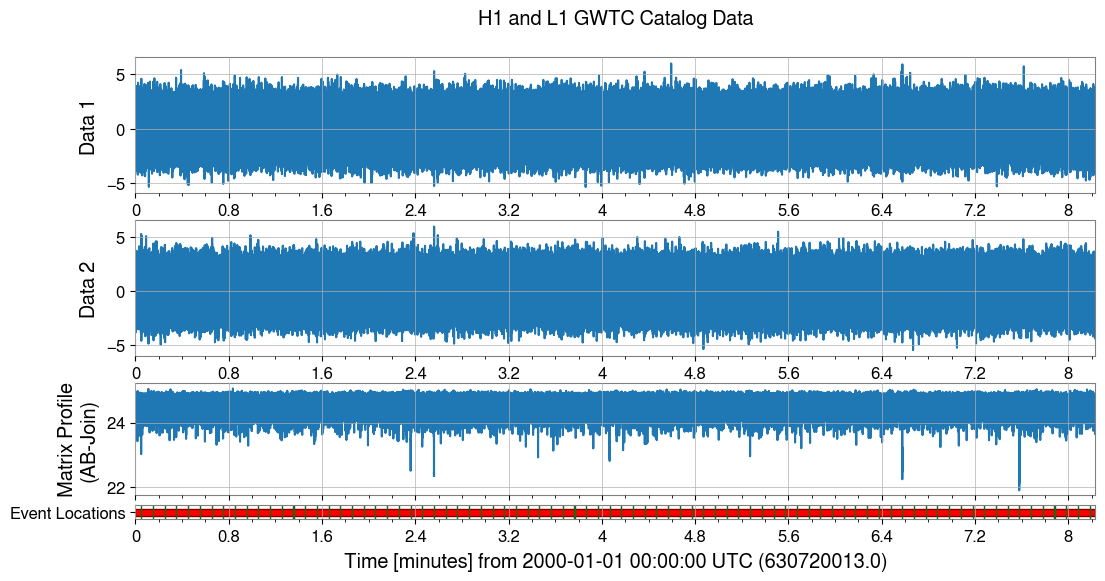

In [30]:
plot = mp_utils.plot_matrix_profile([L1_data_ts, H1_data_ts], mp=H1_L1_data_mp, dqf=labels_dqf, titlestr="H1 and L1 GWTC Catalog Data")

#### Self-join: STUMP-GPU

In [ ]:
H1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, m=motif_len, algo='stump-gpu')
H1_data_mp.shape

Computing the Exact Matrix Profile using STUMP with GPU...
	(timeseries length = 2023332, subsequence length = 400)...
DONE.
Time taken: 0:07:34.613708


(2022933, 4)

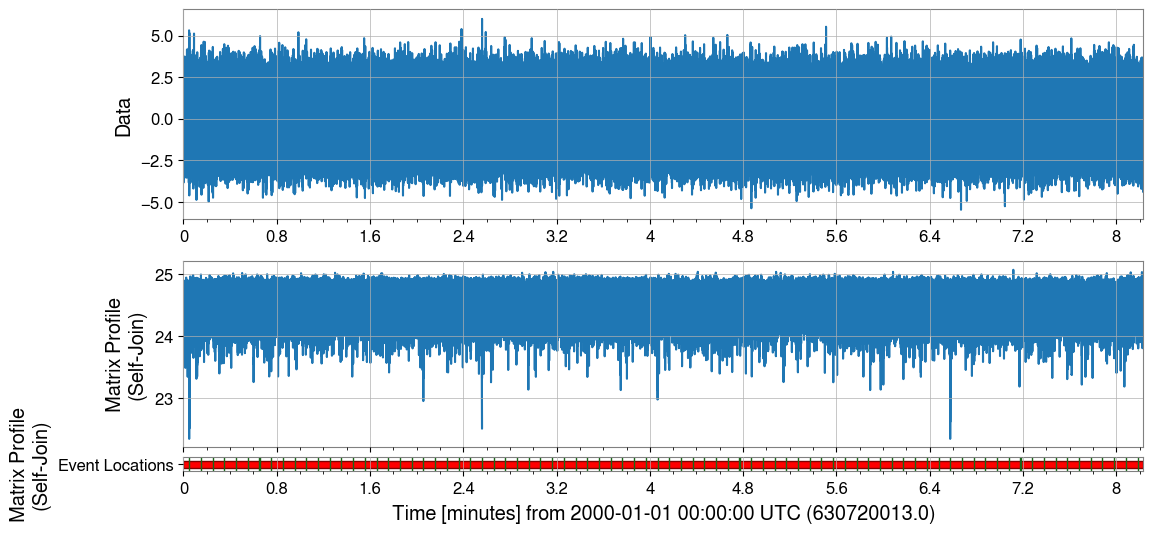

In [ ]:
%matplotlib inline
plot = mp_utils.plot_matrix_profile(H1_data_ts, mp=H1_data_mp, dqf=labels_dqf)

In [ ]:
L1_data_mp = mp_utils.compute_matrix_profile(L1_data_ts.value, m=motif_len, algo='stump-gpu')
L1_data_mp.shape

Computing the Exact Matrix Profile using STUMP with GPU...
	(timeseries length = 2023332, subsequence length = 400)...
DONE.
Time taken: 0:07:31.768502


(2022933, 4)

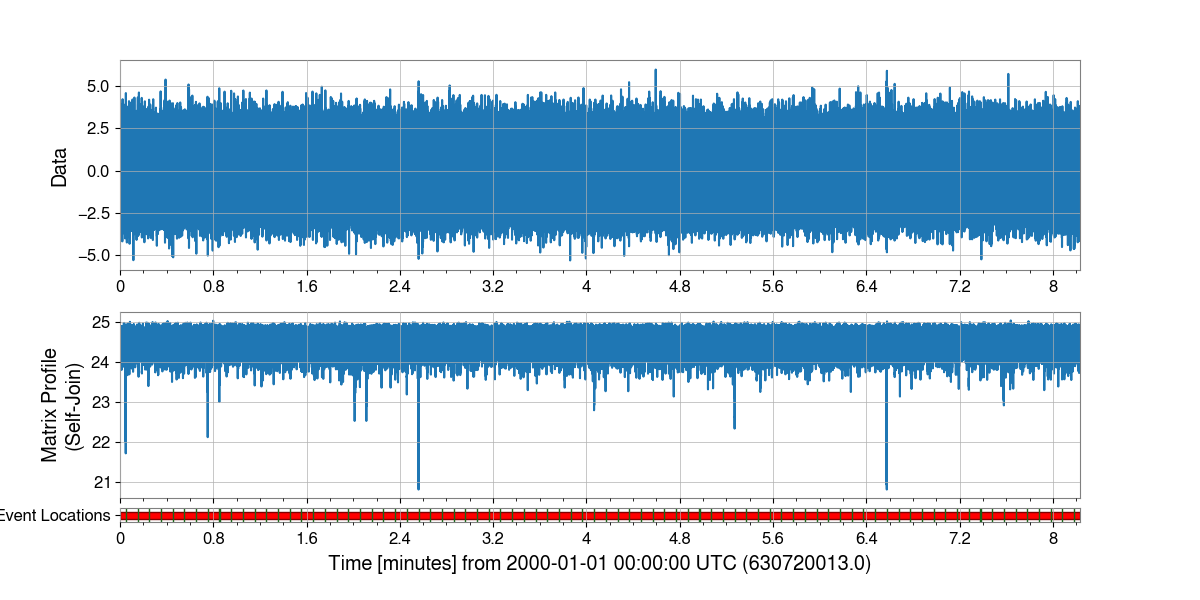

In [ ]:
%matplotlib widget
plot = mp_utils.plot_matrix_profile(L1_data_ts, mp=L1_data_mp, dqf=labels_dqf)

#### AB-join: STUMP-GPU

In [ ]:
H1_L1_data_mp = mp_utils.compute_matrix_profile(L1_data_ts.value, T_B=H1_data_ts.value, m=motif_len, algo='stump-gpu')
H1_L1_data_mp.shape

Computing the Exact Matrix Profile...
	(timeseries length = 2023332, subsequence length = 400)...


/home/rutuja.gurav/.conda/envs/gwsearchenv/lib/python3.9/site-packages/stumpy/core.py:3689: UserWarning: Arrays T_A, T_B are not equal, which implies an AB-join. `ignore_trivial` has been automatically set to `False`.
  warnings.warn(msg)


DONE.
Time taken: 0:06:15.008729


(2022933, 4)

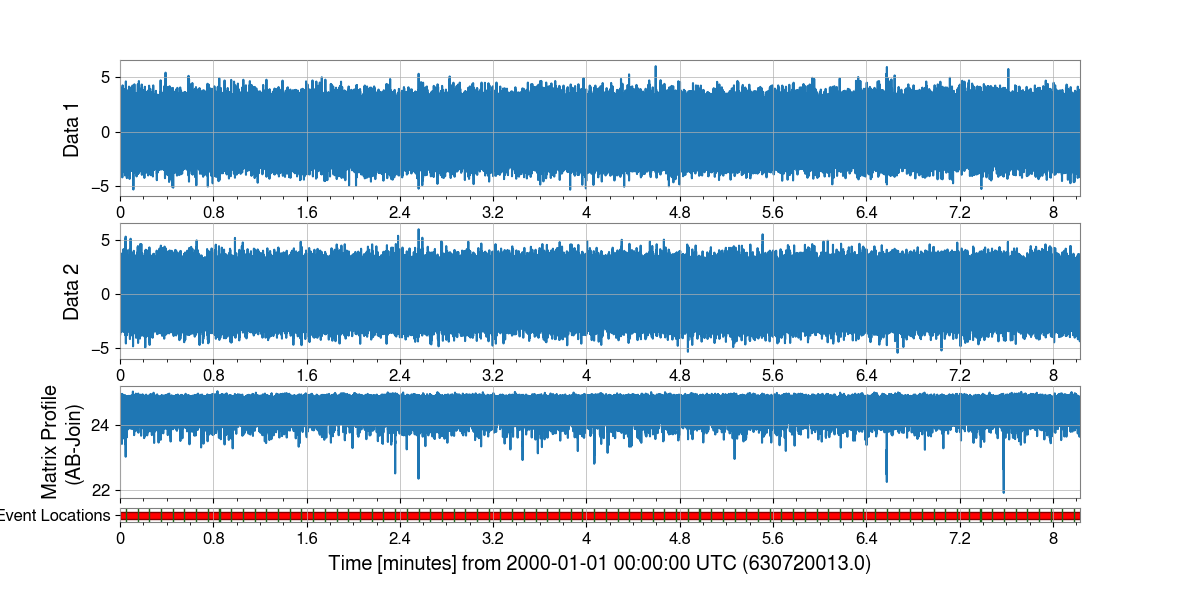

In [ ]:
%matplotlib widget
plot = mp_utils.plot_matrix_profile([L1_data_ts, H1_data_ts], mp=H1_L1_data_mp, dqf=labels_dqf)

#### Self-join: Approx. MP with SCRIMP

In [14]:
H1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, m=motif_len, algo='scrimp')
H1_data_mp.shape

Computing the Approximate Matrix Profile using SCRIMP...
	(timeseries length = 2023332, subsequence length = 400)...
DONE.
Time taken: 0:01:03.821383


(2022933, 2)

In [ ]:
plot = mp_utils.plot_matrix_profile(H1_data_ts, mp=H1_data_mp, dqf=labels_dqf)

In [62]:
L1_data_mp = mp_utils.compute_matrix_profile(L1_data_ts.value, m=motif_len, algo='scrimp')
L1_data_mp.shape

Computing the Approximate Matrix Profile...
	(timeseries length = 2023332, subsequence length = 400)...
DONE.
Time taken: 0:00:49.669220


(2022933, 2)

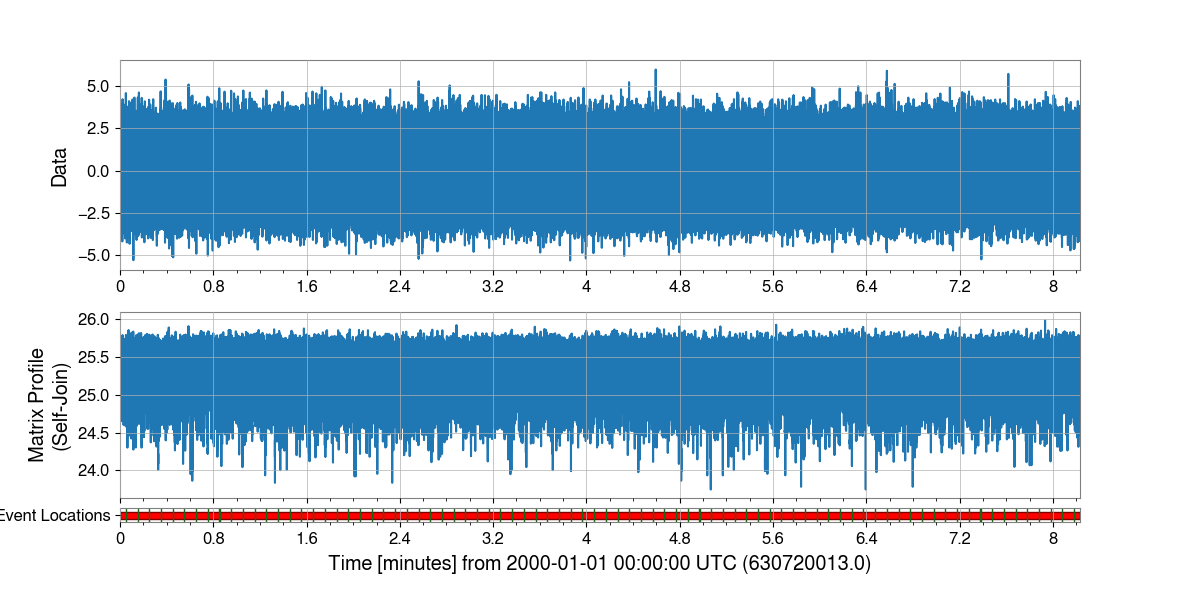

In [63]:
%matplotlib widget
plot = mp_utils.plot_matrix_profile(L1_data_ts, mp=L1_data_mp, dqf=labels_dqf)

#### AB-join: Approx. MP with SCRIMP

In [49]:
H1_L1_data_mp = mp_utils.compute_matrix_profile(L1_data_ts.value, T_B=H1_data_ts.value, m=motif_len, algo='scrimp')
H1_L1_data_mp.shape

Computing the Approximate Matrix Profile...
	(timeseries length = 2023332, subsequence length = 400)...


/home/rutuja.gurav/.conda/envs/gwsearchenv/lib/python3.9/site-packages/stumpy/core.py:3689: UserWarning: Arrays T_A, T_B are not equal, which implies an AB-join. `ignore_trivial` has been automatically set to `False`.
  warnings.warn(msg)


DONE.
Time taken: 0:00:54.898319


(2022933, 2)

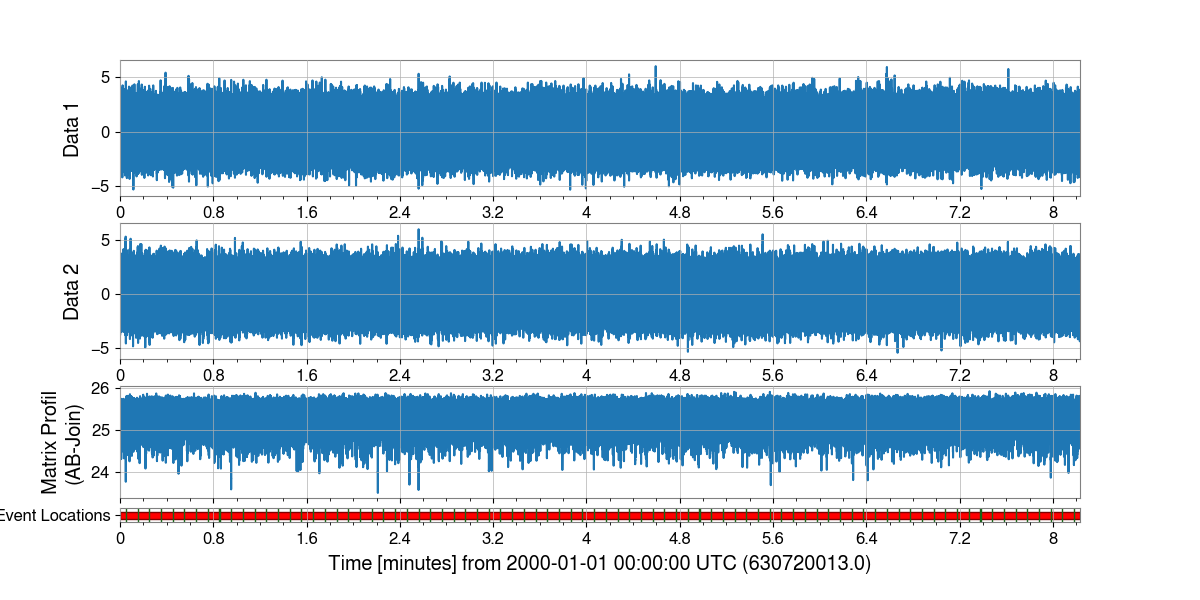

In [51]:
%matplotlib widget
plot = mp_utils.plot_matrix_profile([L1_data_ts, H1_data_ts], mp=H1_L1_data_mp, dqf=labels_dqf)